* Daniel J. Shea
* F15M006C
* Niigata University, Dept. of Agriculture
* Laboratory of Plant Breeding

**2016-04-03:** Based upon our previous work for single chromosomal alignments, `IntroMap` will perform analysis in an attempt to infer possible genomic regions of introgression given the alignment of sequencing data against two reference genomes of high homology to the parental organisms used to create the hybrid introgressed line.

**2016-04-09:** Decided on a name for the software `IntroMap`.  Updated function and variable names reflect that we are calculating scores for called bases.  Fixed plotting labels to reflect the same.

**README Re: What input should be provided for analysis**
* The parental organisms DNA should share a high level of homology w.r.t. their respective supplied reference genomes.
* Sequencing data should be aligned w.r.t. to each of the references and supplied as a BAM formatted file.
* Plots will be generated and saved in pdf format (A4, landscape) from the resulting analysis.

Copyright (c) 2016, Daniel J. Shea, Niigata University, Dept. of Agriculture, Laboratory of Plant Breeding
All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

Load the required libraries to perform the analysis

In [1]:
from Bio import SeqIO
import pysam
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
# Rename the function for easier usage
lowess = sm.nonparametric.lowess

In [2]:
# This function creates a matched vector based upon the alignment segment passed to it
def createMatchVector(alignedSegment):
    '''return a list of 1 (match) and 0 (mismatch) based on MD tag of the alignedSegment'''
    matchVector=list()
    buff=list()
    if alignedSegment.has_tag('MD'):
        mdString = alignedSegment.get_tag('MD')
    for c in mdString:
        if re.match('[0-9]', c):
            buff.append(c)
        else:
            if len(buff) != 0:
                for i in range(int(''.join(buff))):
                    matchVector.append(1)
                buff=list()
            if re.match('[A-Z]', c):
                matchVector.append(0)
    if len(buff) != 0:
        for i in range(int(''.join(buff))):
            matchVector.append(1)
    return matchVector

In [3]:
# This function calculates and returns the number of matches and mismatches defined by the MD tag
def calculateMatch(alignedSegment):
    '''return the number of matches and mismatches defined by the MD tag of the alignedSegment'''
    numMatch = 0
    numMismatch = 0
    matchVector = createMatchVector(alignedSegment)
    numMatch = matchVector.count(1)
    numMismatch = matchVector.count(0)
    return (numMatch, numMismatch)

In [4]:
# This function computes the lengths of sequences within the reference sequence fasta file
def getReferenceLengths(ref):
    ''' Given a fasta with reference sequences return a dictionary with seqid(s) as keys and values as the sequence lengths'''
    seqio = SeqIO.parse(ref, 'fasta')
    refLengths = dict()
    for seqrec in seqio:
        refLengths[seqrec.id] = len(seqrec)
    return refLengths

In [5]:
# This function computes the score given the number of matches and mismatches for a given position
def calculateScore(mismatches, matches):
    ''' Calculate the score of a position given the number of mismatches and matches mapped to that position'''
    # If no mapping exists at the location then the score is 0.0
    if mismatches+matches == 0:
        return 0.0
    else:
        return matches / float(matches + mismatches)

In [6]:
# This function computes the scores of all positions and returns the total number of records processed
# along with the dictionary that holds the computed scores
def calculateScores(infile, reference):
    samfile = pysam.AlignmentFile(infile, 'r')
    recordCount = 0 # The total number of records read in
    refLengths = getReferenceLengths(reference)

    # each refMatches dict entry stores [mismatches, matches] for by position w.r.t. the reference sequence
    # Initialize all positions to 0
    # add 1 to length since python is 0-based and we want to use 1-based positions
    refMatches = {refKey: [[0,0] for i in range(refLengths[refKey]+1)] for refKey in refLengths}
    
    # For each alignedSegment create a matchVector and add the result for that position in the reference
    # to refMatches
    for alignedSegment in samfile.fetch():
        recordCount = recordCount + 1
        refName = alignedSegment.reference_name
        matchVector = createMatchVector(alignedSegment)
        for i,j in zip(range(alignedSegment.pos, alignedSegment.pos + len(matchVector)), range(len(matchVector))):
            # If the position in the matchVector was a 0, this line adds 1 to mismatches,
            # otherwise it adds 1 to matches
            refMatches[refName][i][matchVector[j]] = refMatches[refName][i][matchVector[j]] + 1

    # Then calculate the score for each position and store results in a dictionary,
    # where the reference name is the key that points to a list containing the scores at each position
    # along the reference sequence
    refScores = {refKey: list() for refKey in refLengths}
    for refKey in refMatches:
        for i in refMatches[refKey]:
            refScores[refKey].append(calculateScore(*i))
    
    # Return the number of records and the refScores dict
    return (recordCount, refScores)

Run for the `bowtie2` alignment against _b. rapa_ reference.

* First, we read in the data and calculate the scores.
* Convolve the vector using a sliding window of size 5kbp to compute the mean score of a given coordinate with respect to the surrounding nucleotides.  This is done to reduce noise.
* Next, we apply LOWESS to smooth the signal and plot the resulting estimated curve that fits the data.
* We then plot this using matplotlib.
  * Additionally, we plot a cutoff of a score of 0.90 to show where introgressed regions may lie.

We will make use of mathematical and statistical functions available to us from NumPy in order to perform smoothing on the signal.  In order to reduce noise in the signal.

We can make use of the LOWESS (Locally Weighted Scatterplot Smoothing) function available in the statsmodels package to construct a smooth curve of the signal.

Run the smoothing

* x coordinates are the indices into the `refScores` array
* y coordinates are the calculated score values

The below explanation is taken from http://statsmodels.sourceforge.net/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

>This lowess function implements the algorithm given in the reference below using local linear estimates.
>
>Suppose the input data has N points. The algorithm works by estimating the smooth y_i by taking the frac*N closest points to (x_i,y_i) based on their x values and estimating y_i using a weighted linear regression. The weight for (x_j,y_j) is tricube function applied to abs(x_i-x_j).
>
>If it > 1, then further weighted local linear regressions are performed, where the weights are the same as above times the _lowess_bisquare function of the residuals. Each iteration takes approximately the same amount of time as the original fit, so these iterations are expensive. They are most useful when the noise has extremely heavy tails, such as Cauchy noise. Noise with less heavy-tails, such as t-distributions with df>2, are less problematic. The weights downgrade the influence of points with large residuals. In the extreme case, points whose residuals are larger than 6 times the median absolute residual are given weight 0.

>delta can be used to save computations. For each x_i, regressions are skipped for points closer than delta. The next regression is fit for the farthest point within delta of x_i and all points in between are estimated by linearly interpolating between the two regression fits.

>Judicious choice of delta can cut computation time considerably for large data (N > 5000). A good choice is delta = 0.01 * range(exog).

>Some experimentation is likely required to find a good choice of frac and iter for a particular dataset.


In [7]:
# *** THIS FUNCTION IS DEPRECATED ***
# This function generates plots of the computed scores after calling the above helper functions to
# calculate the positional scores based on the alignment data
# windowSize is the window for the computation of the rolling averages of the positional scores
# frac is the fraction of the frac*N closest positions, where N is the total number of data points
# for the chromosome being analyzed
# *** THIS FUNCTION IS DEPRECATED ***

# Note: This was replaced with writeLowessToFiles and plotFromLowessFiles to separate the calculation
#       from the plotting of the scores. This allows us to generate the scores once and re-plot as
#       many times as we want from the calculated LowessFiles

def plotScores(infile, reference, windowSize=1000, frac=0.05):
    # Calculate the scores for each chromosome
    recordCount, refScores = calculateScores(infile, reference)
    # Display how many records were processed
    print '{0:d} Alignment records were processed from {1:s} using Reference {2:s}'.format(recordCount, infile, reference)
    
    # Calculate the rolling average using a window of size windowSize
    # 1kbp >= windowSize <= 10kbp works well
    averagedScores = {refKey: np.convolve(refScores[refKey], np.ones(windowSize,)/windowSize, mode='valid') for refKey in refScores}
    
    # Perform lowess fitting of the smoothed data using frac passed as argunment or default frac=0.05
    lowess_fits = {refKey: dict() for refKey in averagedScores}
    for refKey in averagedScores:
        numDataPoints = len(averagedScores[refKey])
        lowess_fits[refKey]['y_coords'] = range(numDataPoints)
        lowess_fits[refKey]['Delta']    = int(np.floor(0.01 * numDataPoints))
    
    for refKey in lowess_fits:
        lowess_fits[refKey]['fit'] = lowess(averagedScores[refKey],
                                     lowess_fits[refKey]['y_coords'], frac=frac,
                                     delta=lowess_fits[refKey]['Delta'], is_sorted=True)
        
    # Plot the fitted functions
    for refKey in lowess_fits:
        plt.xlabel('Coordinate')
        plt.ylabel('Score')
        plt.title('Reads aligned to '+refKey)
        plt.plot(averagedScores[refKey], 'blue', linewidth=1)
        plt.plot(lowess_fits[refKey]['fit'][:,1], 'yellow', linewidth=2)
        plt.axhline(y=0.9, color='pink')
        plt.savefig(refKey+'_1kconvolved_lowess.pdf', orientation='landscape', papertype='a4', bbox_inches='tight')
        plt.show()

In [8]:
# This function outputs the calculated fits to files, so they can be re-used without having to run
# the entire calculation again
def writeLowessToFiles(infile, reference, outfile, windowSize=1000, frac=0.05):
    '''Calculate the lowess fits and write them to files, return a list of the filenames for later use'''
    # Calculate the scores for each chromosome
    recordCount, refScores = calculateScores(infile, reference)
    # Display how many records were processed
    print '{0:d} Alignment records were processed from {1:s} using Reference {2:s}'.format(recordCount, infile, reference)
    
    # Calculate the rolling average using a window of size windowSize
    # 1kbp >= windowSize <= 10kbp works well
    averagedScores = {refKey: np.convolve(refScores[refKey], np.ones(windowSize,)/windowSize, mode='valid') for refKey in refScores}
    
    # Perform lowess fitting of the smoothed data using frac passed as argunment or default frac=0.05
    lowess_fits = {refKey: dict() for refKey in averagedScores}
    for refKey in averagedScores:
        numDataPoints = len(averagedScores[refKey])
        lowess_fits[refKey]['y_coords'] = range(numDataPoints)
        lowess_fits[refKey]['Delta']    = int(np.floor(0.01 * numDataPoints))
    
    for refKey in lowess_fits:
        lowess_fits[refKey]['fit'] = lowess(averagedScores[refKey],
                                     lowess_fits[refKey]['y_coords'], frac=frac,
                                     delta=lowess_fits[refKey]['Delta'], is_sorted=True)
    
    filesWritten = list()
    for refKey in lowess_fits:
        outfileByKey = refKey + '.' + outfile
        with open(outfileByKey, 'w') as fh:
            numRecords = 0
            for y_val in lowess_fits[refKey]['fit'][:,1]:
                fh.write('{}\n'.format(y_val))
                numRecords = numRecords + 1
            print '{0:d} records were processed for {1:s}'.format(numRecords, refKey)
        filesWritten.append(outfileByKey)
    
    return filesWritten

In [9]:
# This function reads output files created by writeLowessToFiles when re-using pre-computed
# fitted scores
def readLowessFile(filename):
    '''return a numpy array of the values listed in the .out file'''
    lowess_yvals = list()
    with open(filename, 'r') as fh:
        for y_val in fh:
            y_val = y_val.strip()
            y_val = float(y_val)
            lowess_yvals.append(y_val)
    return np.array(lowess_yvals)

In [10]:
# This function returns tuples of positions where the lowess fitted values have fallen below threshold
# If below is set to False, we instead return the tuples of values that are equal to or above threshold.
def printRegions(Chromosome, diffArray, outfile, below=True, threshold=0.90):
    '''Given a numpy array containing the lowess fit values
       print the start and end indices of runs above or below threshold as indicated by the below argument.
       (below=False means print regions above threshold)
       These correspond to the coordinates of likely regions of introgression.
       (Coordinates returned are 1-based chromosome coordinates, so we are returning
       startIndex+1 and endIndex+1 here.)
       
       Returns a list of the 0-based start and end coordinates as tuples.
    '''
    with open(outfile, 'w') as fh:
        # Flag to let us know when we enter a region of positive values (value < threshold)
        # Set it back to False when we encounter a negative value
        startFlag = False
        # here we set index to be 0 because the first thing we do in the loop is set it to 1
        # this gives us a 1-based index into the array since we are evaluating diffArray[0]
        # when we have index set to 1
        index = 0
        # Store the 0-based start and end+1 coordinates (for slicing) as tuples in a list and return it
        regions = list()
        if below:
            for i in diffArray:
                index = index + 1
                if startFlag == False and i < threshold:
                    startFlag = True
                    startIndex = index
                elif startFlag == True and i < threshold:
                    continue
                elif startFlag == True and i >= threshold:
                    startFlag = False
                    output='{}\t{}\t{}'.format(Chromosome, startIndex, index-1)
                    regions.append((startIndex-1, index))
                    print output
                    fh.write(output+'\n')
        else:
            for i in diffArray:
                index = index + 1
                if startFlag == False and i >= threshold:
                    startFlag = True
                    startIndex = index
                elif startFlag == True and i >= threshold:
                    continue
                elif startFlag == True and i < threshold:
                    startFlag = False
                    output='{}\t{}\t{}'.format(Chromosome, startIndex, index-1)
                    regions.append((startIndex-1, index))
                    print output
                    fh.write(output+'\n')
        # BUGFIX for complete chromosomal introgression and tail introgressions (Fencepost type error)
        # If we have scanned to the end of a chromosome and the startFlag still equals True,
        # then we should output appropriate coordinates as well coordinates
        if startFlag == True:
            output='{}\t{}\t{}'.format(Chromosome, startIndex, index-1)
            regions.append((startIndex-1, index))
            print output
            fh.write(output+'\n')
        
        return regions

In [11]:
# This function generates plots from LowessFiles computed using the writeLowessToFiles function
# BUGFIX: matplotlib is throwing MemoryError when generating plots in a loop and saving as pdf
# I have changed to png output and explicitly close the figure at the end of the loop,
# so that the resources are freed each iteration.
def plotFromLowessFiles(infiles, below=True, threshold=0.90):
    for lowessFile in sorted(infiles):
        Chromosome   = lowessFile.split('.')[0]
        queryName    = lowessFile.split('.')[1]
        refName      = lowessFile.split('.')[2]
        lowessValues = readLowessFile(lowessFile)
        outfileName  = '.'.join([Chromosome,queryName,refName,'predicted','out'])
        regions = printRegions(Chromosome, lowessValues, outfileName, below, threshold)
        # plot the fitted function
        plt.xlabel('{} Coordinate (bp)'.format(Chromosome))
        plt.ylabel('Homology Score')
        plt.title(' '.join([queryName,'aligned','to',refName,'-',Chromosome]))
        plt.plot(lowessValues, '#0F9400', linewidth=1)
        for startX, endX in regions:
            plt.plot([startX, endX], [0, 0], '#C75800', linewidth=20)
        plt.axhline(y=threshold, color='purple')
        plt.text(plt.gca().get_xlim()[1]+1e6,threshold,'Threshold',color='purple')
        #plt.savefig('_'.join([Chromosome,queryName,refName,'predicted.pdf']), orientation='landscape', papertype='a4', bbox_inches='tight')
        plt.savefig('_'.join([Chromosome,queryName,refName,'predicted.png']), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close('all')

For the background genome alignment, we test for cases where the score falls below the threshold value.

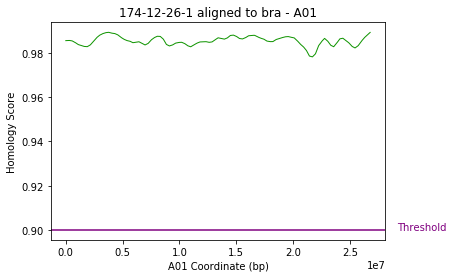

A02	228453	6213700


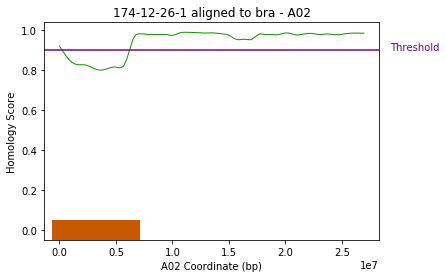

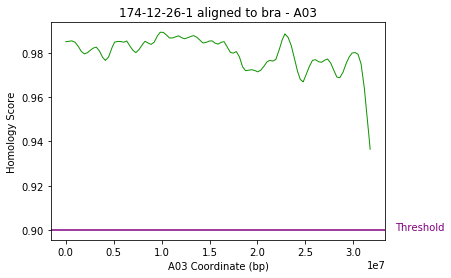

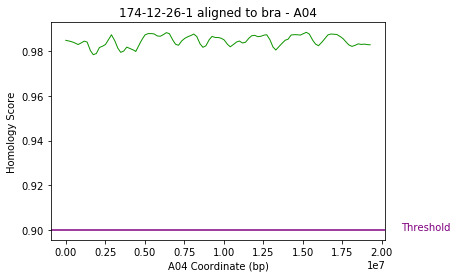

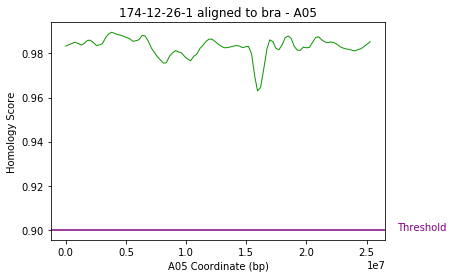

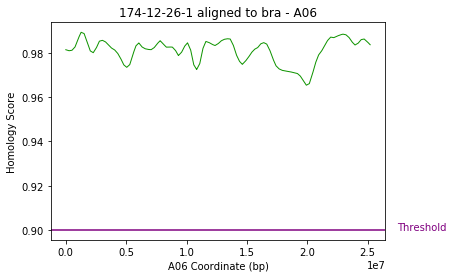

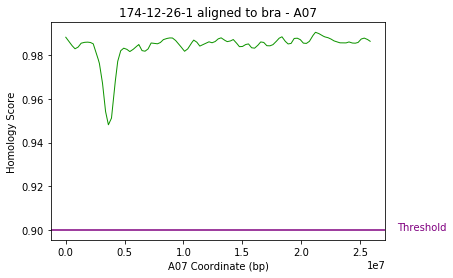

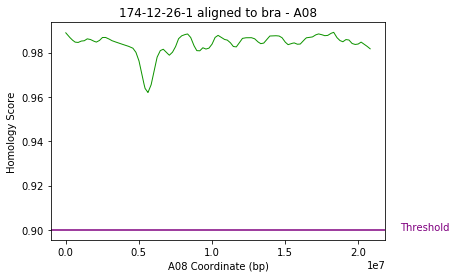

A09	1	3703909


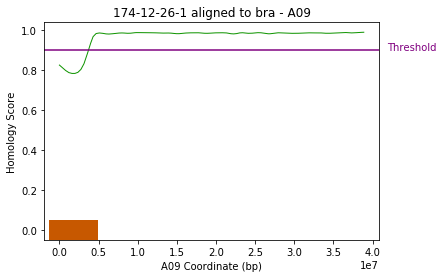

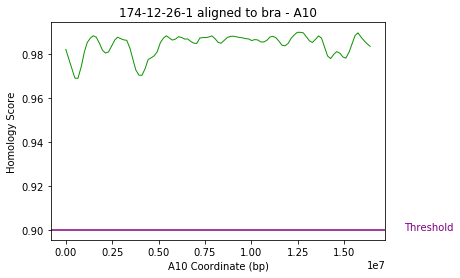

In [13]:
# Comment this out and uncomment the section below to use outputs already generated from writeLowessToFiles()
#infiles = writeLowessToFiles('./bowtie2_alignment/against_bra/174-12-26-1-28280253.bra.bowtie2.sorted.nodups.bam',
#                             './bowtie2_alignment/against_bra/bra.fa',
#                             '174-12-26-1.bra.out')

# Uncomment this to use outputs already generated from writeLowessToFiles()
infiles = ['A01.174-12-26-1.bra.out',
           'A02.174-12-26-1.bra.out',
           'A03.174-12-26-1.bra.out',
           'A04.174-12-26-1.bra.out',
           'A05.174-12-26-1.bra.out',
           'A06.174-12-26-1.bra.out',
           'A07.174-12-26-1.bra.out',
           'A08.174-12-26-1.bra.out',
           'A09.174-12-26-1.bra.out',
           'A10.174-12-26-1.bra.out',]

# Create the plots
plotFromLowessFiles(infiles)

Before running the next set of analyses we copy the outputs out of the way and store them in another directory for later use in ROC analysis.

41223330 Alignment records were processed from ./bowtie2_alignment/against_bol/174-12-26-1-28280253.bol.bowtie2.sorted.nodups.bam using Reference ./bowtie2_alignment/against_bol/bol.fa
41515066 records were processed for C08
40125858 records were processed for C09
38760722 records were processed for C01
44045005 records were processed for C02
57780465 records were processed for C03
40894477 records were processed for C04
32827330 records were processed for C05
40703473 records were processed for C06
48345210 records were processed for C07
C01	1	38760721


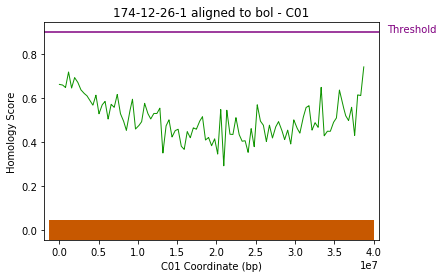

C02	1	1844059
C02	2572075	3783293
C02	4149518	4768749
C02	5473129	6029022
C02	6267355	7407693
C02	7679288	8290787
C02	8878171	9547337
C02	9828246	44045004


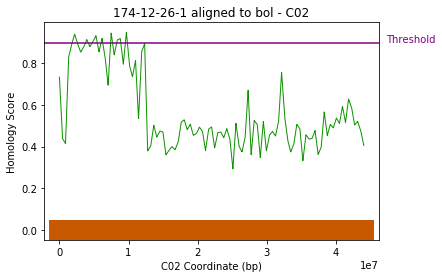

C03	1	57780464


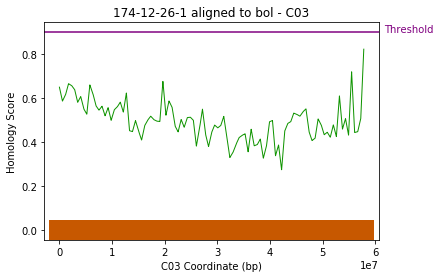

C04	1	40894476


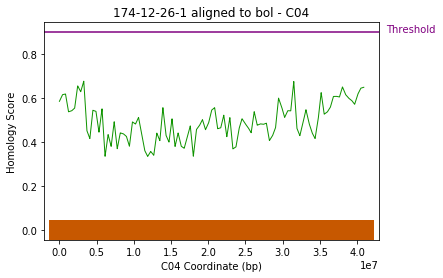

C05	1	32827329


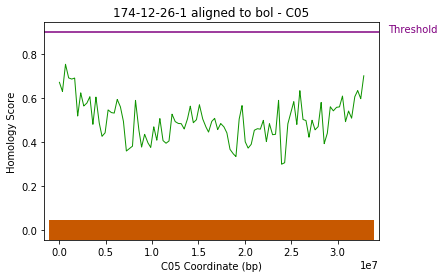

C06	1	40703472


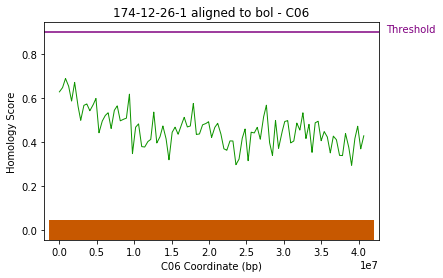

C07	1	48345209


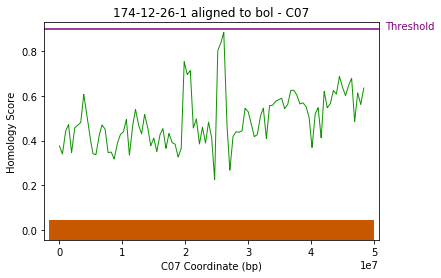

C08	1	41515065


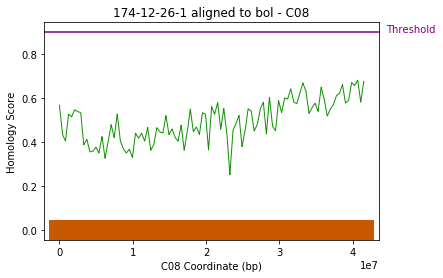

C09	308081	1772451
C09	2423509	3542803
C09	3663387	40125857


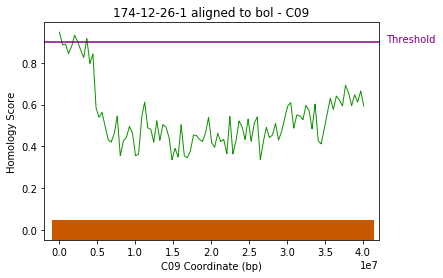

In [12]:
# Reverse ROC shows that frac=0.01 and t=0.90 are optimal
# Comment this out and uncomment the section below to use outputs already generated from writeLowessToFiles()
infiles = writeLowessToFiles('./bowtie2_alignment/against_bol/174-12-26-1-28280253.bol.bowtie2.sorted.nodups.bam',
                             './bowtie2_alignment/against_bol/bol.fa',
                             '174-12-26-1.bol.out', frac=0.01)

# Uncomment this to use outputs already generated from writeLowessToFiles()
#infiles = ['C01.174-12-26-1.bol.out',
#           'C02.174-12-26-1.bol.out',
#           'C03.174-12-26-1.bol.out',
#           'C04.174-12-26-1.bol.out',
#           'C05.174-12-26-1.bol.out',
#           'C06.174-12-26-1.bol.out',
#           'C07.174-12-26-1.bol.out',
#           'C08.174-12-26-1.bol.out',
#           'C09.174-12-26-1.bol.out',]

# Create the plots
plotFromLowessFiles(infiles, threshold=0.90)